In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
df = pd.read_csv("BTCUSDT-1m-2023-11.csv")
df.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1698796800000,34651.4,34676.5,34650.0,34669.9,376.040,1698796859999,1.303610e+07,4214,199.885,6.929501e+06,0
1,1698796860000,34669.9,34684.0,34637.3,34637.4,431.177,1698796919999,1.494828e+07,4495,229.490,7.957308e+06,0
2,1698796920000,34637.4,34653.4,34632.5,34651.4,175.894,1698796979999,6.093655e+06,2669,71.494,2.476893e+06,0
3,1698796980000,34651.3,34651.4,34608.6,34621.1,476.587,1698797039999,1.650097e+07,5182,89.613,3.102759e+06,0
4,1698797040000,34621.1,34622.6,34592.0,34615.4,546.312,1698797099999,1.890390e+07,5557,214.962,7.438203e+06,0


### Converts input to suitable form for LSTM Model (predicting today's price using previous 10 prices)

In [ ]:
def sequence(close, length):
    x = []
    y = []
    for i in range(len(close) - length):
        x.append(close[i:(i + length), 0])
        y.append(close[i + length, 0])
    seq = np.array(x)
    cur = np.array(y)
    return seq, cur

#### Normalise the given input between 0 and 1 to improve results and get sequences

In [ ]:
close = df['close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
norm_close = scaler.fit_transform(close)

sequences, curr = sequence(norm_close, 10)

#### Splitting into train and test data and close prices

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sequences, curr, test_size=0.2, random_state=50)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train.shape

(34552, 10, 1)

#### Model creation


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

#### Model training

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10

1080/1080 [==============================] - 14s 8ms/step - loss: 0.0021
Epoch 2/10
1080/1080 [==============================] - 9s 9ms/step - loss: 1.1469e-04
Epoch 3/10
1080/1080 [==============================] - 9s 8ms/step - loss: 1.1151e-04
Epoch 4/10
1080/1080 [==============================] - 9s 8ms/step - loss: 1.0765e-04
Epoch 5/10
1080/1080 [==============================] - 9s 8ms/step - loss: 9.7230e-05
Epoch 6/10
1080/1080 [==============================] - 9s 9ms/step - loss: 8.0715e-05
Epoch 7/10
1080/1080 [==============================] - 9s 8ms/step - loss: 6.4348e-05
Epoch 8/10
1080/1080 [==============================] - 9s 8ms/step - loss: 5.5471e-05
Epoch 9/10
1080/1080 [==============================] - 9s 8ms/step - loss: 4.8130e-05
Epoch 10/10
1080/1080 [==============================] - 9s 8ms/step - loss: 3.9647e-05


#### Loss on test data

In [ ]:
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on the test set:', {loss})

270/270 [==============================] - 2s 4ms/step - loss: 2.9608e-05
Mean Squared Error on the test set: {2.960776873806026e-05}


### Generating signals based on the model's predictions for all data points

In [ ]:
def signals(model, sequence, actual, length):
    predictions = model.predict(sequence)
    signal = []
    for i in range(length):
        signal.append(0)
    for i in range(len(actual)):
        if(predictions[i][0] - actual[i] > 0.02):
            signal.append(1)
        elif(predictions[i][0] - actual[i] < -0.02):
            signal.append(-1)
        else:
            signal.append(0)
    return pd.Series(signal)

In [ ]:
s = np.reshape(sequences, (sequences.shape[0], sequences.shape[1], 1))
signal = signals(model, s, curr, 10)
type(signal)
print(len(close))

1350/1350 [==============================] - 5s 4ms/step
43200


### Backtester (same as of trend analysis)

In [ ]:
def backtester(close, signal, stop_loss = 0.1):
    '''
    parameters:
        close - closing prices (pd Series object)
        signal - buy/sell signal (pd Series object)
        stop_loss - if difference is more than 0.1 times, then stop loss triggered
    returns:
        port - portfolio across time (pd Series object)
    '''
    amt = close.iat[0] # initial amount
    num = 0
    portfolio = []
    buy_price = 0
    num_trades = 0
    for i in range(len(close)):
        # if signal is buy, we buy num number of BTC and amt changes to 0
        if(buy_price == 0 and signal.iat[i] == 1):
            num = amt/close.iat[i]
            amt = 0
            buy_price = close.iat[i]
            num_trades += 1
        # if signal is sell, we sell num number of BTC to get num * current closing price
        elif(buy_price != 0 and signal.iat[i] == -1):
            amt = num * close.iat[i]
            num = 0
            buy_price = 0
            num_trades += 1
        elif(buy_price != 0 and close.iat[i] < (1-stop_loss)*buy_price):
            amt = num * close.iat[i]
            num = 0
            buy_price = 0
            num_trades += 1
        portfolio.append(amt + num * close.iat[i])
    port = pd.Series(portfolio, index=close.index)
    return port, num_trades

### Plotting predictions vs Close prices

Starting amount: 34669.9
Final amount: 37874.169090711956
Profit percentage = 9.242221900587989 %
Number of trades =  109
37874.169090711956


<Axes: >

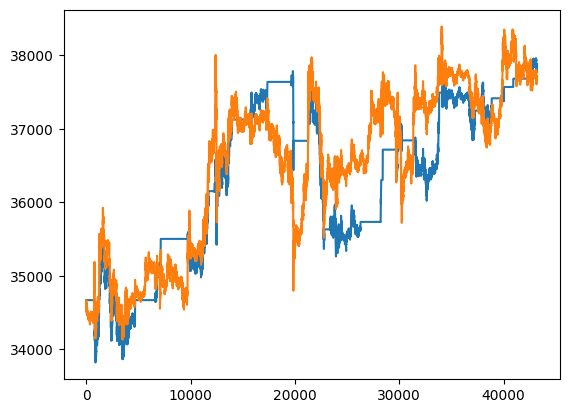

In [ ]:
portfolio, num_trades = backtester(df['close'], signal)
print("Starting amount:", portfolio.iat[0])
print("Final amount:", portfolio.iat[len(portfolio)-1])
print("Profit percentage =", (portfolio.iat[len(portfolio)-1]/portfolio.iat[0]-1)*100,"%")
print("Number of trades = ", num_trades)
print(portfolio[len(portfolio)-1])
portfolio.plot()
df['close'].plot()